# Tutorial 2: Slab Transmission

This tutorial will walk you through computing transmission spectrum of a dielectric slab using Tidy3d.

For more details, refer to the [Tidy3d documentation](https://docs.simulation.cloud/projects/tidy3d/en/latest).

## Setup

First we import Tidy3d and the other packages needed.  If it is not installed, please do so with `pip install tidy3d-beta`.



## Introduction / Setup



In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d import web

First, let us define some basic parameters setting up the slab and other simulation properties.

In [2]:
# dots per inch (image quality)
DPI = 300

# Wavelength and frequency range
freq_range = (200e12, 400e12)
lambda_range = (td.constants.C_0/freq_range[1], td.constants.C_0/freq_range[0])
freq0 = np.sum(freq_range)/2
Nfreq = 301

# frequencies and wavelengths of monitor
monitor_freqs = np.linspace(freq_range[0], freq_range[1], Nfreq)
monitor_lambdas = td.constants.C_0 / monitor_freqs

# central frequency, frequency pulse width and total running time
lambda0 = td.C_0 / freq0
bandwidth = 0.18  # bandwidth of source in units of delta frequency.  0.38 for broadband

freqw  = bandwidth * (freq_range[1] - freq_range[0])
t_stop = 100 / freq0

# Thickness and refractive index of slab
t_slab = 0.5
n_slab = 3.5
mat_slab = td.Medium(permittivity=n_slab**2)

# Grid resolution (cells per um)
# dl = lambda_range[0] / 30 / n_slab
dl = 6e-3

# space between slabs and sources and PML
spacing = 1 * lambda_range[-1]

# simulation size
sim_size = Lx, Ly, Lz = (2.0, 2.0, 2*spacing + t_slab)

## Analytical Method

First, let's use the analytical expresion for slab transmission to see what we should expect.

In [3]:
def slab_analytical(d, n, wvl):
    """ computes transmision as a function of slab thickness (d), refractive index (n), and wavelength (wvl). """
    rho = (n-1)/(n+1)
    t = ((1+rho)*(1-rho)*np.exp(-2j*np.pi*n*d/wvl)) / (1 - rho**2*np.exp(-4j*np.pi*n*d/wvl))
    return np.abs(t)**2

transmission_analytical = slab_analytical(t_slab, n_slab, monitor_lambdas)

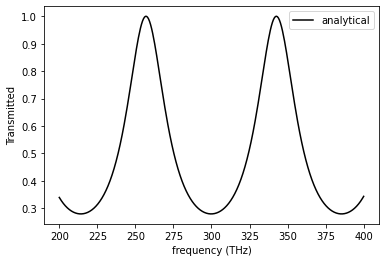

In [4]:
plt.figure()
plt.plot(monitor_freqs / 1e12, transmission_analytical, 'k', label='analytical')
plt.xlabel('frequency (THz)')
plt.ylabel('Transmitted')
plt.legend()
plt.show()

## Create Simulation
Now we set everything else up (structures, sources, monitors, simulation) to run the example.

First, we define the multilayer stack structure.

In [5]:
slab = td.Structure(
    geometry=td.Box(
        center=(0, 0, -Lz/2 + spacing + t_slab/2),
        size=(td.inf, td.inf, t_slab),
    ),
    medium=mat_slab,
)

We must now define the excitation conditions and field monitors. We will excite the slab using a normally incident (along z) planewave, polarized along the x direciton.

In [6]:
# Here we define the planewave source, placed just in advance (towards negative z) of the slab
source = td.PlaneWave(
    source_time = td.GaussianPulse(
        freq0=freq0,
        fwidth=freqw
    ),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -Lz/2+spacing/2),
    direction='+',
    pol_angle=0,
)

Here we define the field monitor, placed just past (towards positive z) of the stack.

In [7]:
# We are interested in measuring the transmitted flux, so we set it to be an oversized plane.
monitor = td.FluxMonitor(
    center = (0, 0, Lz/2 - spacing/2),
    size = (td.inf, td.inf, 0),
    freqs = monitor_freqs,
    name='flux',
)

Now it is time to define the simulation object.

In [8]:
sim = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    grid_spec = td.GridSpec.uniform(dl=dl),
    structures = [slab],
    sources = [source],
    monitors = [monitor],
    run_time = t_stop,
    pml_layers = (None, None, td.PML())
)

## Plot The Structure

Let's now plot the permittivity profile to confirm that the structure was defined correctly.

First we use the `Simulation.plot()` method to plot the materials only, which assigns a different color to each slab without knowledge of the material properties.

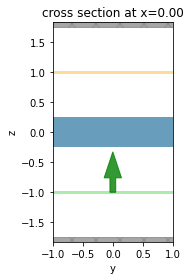

In [9]:
sim.plot(x=0)
plt.show()

Next, we use `Simulation.plot_eps()` to vizualize the permittivity of the stack. However, because the stack contains dispersive materials, we need to specify the `freq` of interest as an argument to the plotting tool.  Here we show the permittivity at the lowest and highest frequences in the range of interest.  Note that in this case, the real part of the permittivity (being plotted) only changes slightly between the two frequencies on the dispersive material.  However, for other materials with more dispersion, the effect can be much more prominent.

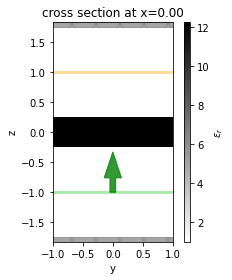

In [11]:
# plot the permittivity 
freqs_plot = (freq_range[0], freq_range[1])
fig, ax = plt.subplots(1, tight_layout=True, figsize=(8, 4))
sim.plot_eps(x=0, freq=None, ax=ax)
plt.show()

In [12]:
times = np.arange(0, sim.run_time, sim.dt)
amps = np.real(sim.sources[0].source_time.amp_time(times))

We can also take a look at the source to make sure it's defined correctly over our frequency range of interst.

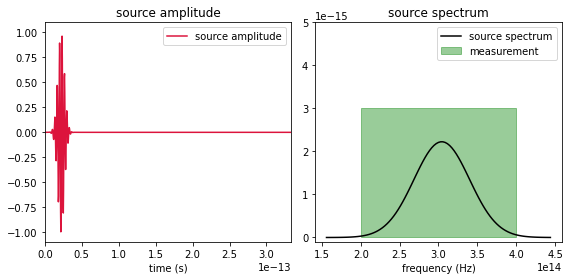

In [13]:
# Check probe and source
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
ax1 = sim.sources[0].source_time.plot(times=np.linspace(0, sim.run_time, 1001), ax=ax1)
ax1.lines.pop(0)
ax1.lines.pop(1)
ax1.set_xlim(0, sim.run_time)
ax1.legend(('source amplitude',))
ax2 = sim.sources[0].source_time.plot_spectrum(times=np.linspace(0, sim.run_time, 1001), ax=ax2)
ax2.lines.pop(0)
ax2.lines.pop(0)
fill_max = 30e-16 # 10e-16
ymax = 50e-16 # 20e-16
ax2.fill_between(freq_range, [-0e-16, -0e-16], [fill_max, fill_max], alpha=0.4, color='g')
ax2.legend(('source spectrum', 'measurement'))
ax2.set_ylim(-1e-16, ymax)
plt.show()

### Define Normalization Simulation

To compare the results with and without the slab, let's make a copy of our simulation and remove the slab.
This will be our reference for normalization.

In [14]:
sim0 = sim.copy(deep=True)
sim0.structures=[]

## Run the simulations

We will submit both simulations to run.

In [15]:
sim_data0 = web.run(sim0, task_name='slab_normalization', path=f'data/sim_data0.hdf5', normalize_index=None)
sim_data = web.run(sim, task_name='slab_transmission', path=f'data/sim_data.hdf5', normalize_index=None)

[09:24:51] INFO     Using Tidy3D credentials from stored file                      ]8;id=703443;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=348159;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py#74\74]8;;\

[09:24:54] INFO     Uploaded task 'slab_normalization' with task_id             ]8;id=272620;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=658378;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    'eb692ed2-9cde-4481-8949-dc7e03e99eaf'.

[09:24:55] INFO     Maximum flex unit cost: 0.58                                ]8;id=369932;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=891915;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#141\141]8;;\

Output()

[09:25:04] INFO     status = preprocess                                         ]8;id=991398;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=913420;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#263\263]8;;\

[09:25:24] INFO     starting up solver                                          ]8;id=953894;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=312189;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#267\267]8;;\

[09:25:57] INFO     running solver                                              ]8;id=198471;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=208512;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#272\272]8;;\

Output()

% done (field decay = 2.31e-12) ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  16% -:--:--

Output()

[09:26:07] INFO     status = postprocess                                        ]8;id=6760;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=754151;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[09:26:19] INFO     status = success                                            ]8;id=290391;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=990906;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#296\296]8;;\

[09:26:20] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=38955;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=96415;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#522\522]8;;\
                    "data/sim_data0.hdf5"

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

           INFO     loading SimulationData from data/sim_data0.hdf5             ]8;id=670588;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=257829;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

[09:26:22] INFO     Uploaded task 'slab_transmission' with task_id              ]8;id=764272;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=43490;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    '9076dfb3-3635-4f8f-a343-d27afaf61783'.

[09:26:24] INFO     Maximum flex unit cost: 0.58                                ]8;id=848343;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=430372;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#141\141]8;;\

Output()

[09:26:33] INFO     status = preprocess                                         ]8;id=278249;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=95424;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#263\263]8;;\

[09:26:51] INFO     starting up solver                                          ]8;id=710018;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=731638;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#267\267]8;;\

[09:27:44] INFO     running solver                                              ]8;id=106929;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=38182;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#272\272]8;;\

Output()

[09:27:50] INFO     early shutoff detected, exiting.                            ]8;id=641237;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=408417;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#282\282]8;;\

% done (field decay = 6.67e-06) ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━  28% -:--:--

Output()

[09:27:54] INFO     status = postprocess                                        ]8;id=771405;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=690983;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[09:28:06] INFO     status = success                                            ]8;id=226953;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=732171;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[09:28:10] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=900120;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=821577;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#522\522]8;;\
                    "data/sim_data.hdf5"

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

           INFO     loading SimulationData from data/sim_data.hdf5              ]8;id=917048;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=917200;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

## Postprocess and Plot

Once the simulation has completed, we can download the results and load them into the simulation object.

Now, we compute the transmitted flux and plot the transmission spectrum.

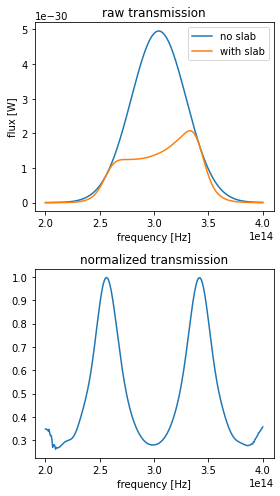

In [16]:
# Retrieve the power flux through the monitor plane.
transmission0 = sim_data0['flux']
transmission = sim_data['flux']
transmission_normalized = transmission / transmission0

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 7), tight_layout=True)
transmission0.plot(ax=ax1, label='no slab')
transmission.plot(ax=ax1, label='with slab')
transmission_normalized.plot(ax=ax2)
ax1.legend()
ax1.set_title('raw transmission')
ax2.set_title('normalized transmission')
plt.show()

We notice that at the edges of the frequency spectrum, the results look a bit strange.

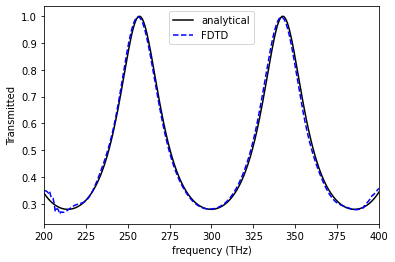

In [17]:
plt.figure()
plt.plot(monitor_freqs/1e12, transmission_analytical, 'k', label='analytical')
plt.plot(monitor_freqs/1e12, transmission_normalized, 'b--', label='FDTD')
plt.xlabel('frequency (THz)')
plt.xlim([200, 400])
plt.ylabel('Transmitted')
plt.legend()
plt.show()

And also dont match the analytical.  

## Inreasing Source Bandwdith

Those results show some strange behavior at the edge frequencies.
As we discuss in the lecture, it is likely due to the source spectrum not having enough power in those regions.
So let's increase the source bandwidth and try again.


In [18]:
bandwidth = 0.38

freqw  = bandwidth * (freq_range[1] - freq_range[0])

# make a copy of the original simulation, but change the frequency width of the source
sim_bw = sim.copy(deep=True)
sim_bw.sources[0].source_time.fwidth = freqw

# make the normalization simulation for this
sim_bw0 = sim_bw.copy(deep=True)
sim_bw0.structures = []

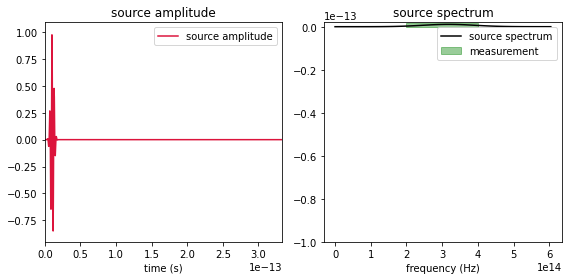

In [19]:
# Check probe and source, looks now like the source spectrum fully covers the green square
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
ax1 = sim_bw.sources[0].source_time.plot(times=np.linspace(0, sim_bw.run_time, 1001), ax=ax1)
ax1.lines.pop(0)
ax1.lines.pop(1)
ax1.set_xlim(0, sim_bw.run_time)
ax1.legend(('source amplitude',))
ax2 = sim_bw.sources[0].source_time.plot_spectrum(times=np.linspace(0, sim_bw.run_time, 1001), ax=ax2)
ax2.lines.pop(0)
ax2.lines.pop(0)
fill_max = 15e-16
ymax = 20e-16
ax2.fill_between(freq_range, [-0e-16, -0e-16], [fill_max, fill_max], alpha=0.4, color='g')
ax2.legend(('source spectrum', 'measurement'))
ax2.set_ylim(-1e-13, ymax)
plt.show()

In [20]:
sim_bw_data0 = web.run(sim_bw0, task_name='slab_normalization', path=f'data/sim_data0_bw.hdf5', normalize_index=None)
sim_bw_data = web.run(sim_bw, task_name='slab_transmission', path=f'data/sim_data_bw.hdf5', normalize_index=None)

[09:28:13] INFO     Uploaded task 'slab_normalization' with task_id             ]8;id=785720;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=775612;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    'ab07b0d2-e72c-415d-90c9-2016a53da5cc'.

[09:28:15] INFO     Maximum flex unit cost: 0.58                                ]8;id=306563;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=512371;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#141\141]8;;\

Output()

[09:28:23] INFO     status = preprocess                                         ]8;id=232575;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=203583;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#263\263]8;;\

[09:28:37] INFO     starting up solver                                          ]8;id=786831;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=670582;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#267\267]8;;\

[09:28:58] INFO     running solver                                              ]8;id=811843;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=866130;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#272\272]8;;\

Output()

% done (field decay = 2.06e-06) ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   8% -:--:--

Output()

[09:29:06] INFO     status = postprocess                                        ]8;id=102312;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=807662;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[09:29:10] INFO     status = success                                            ]8;id=598837;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=330464;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[09:29:14] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=425545;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=16732;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#522\522]8;;\
                    "data/sim_data0_bw.hdf5"

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

[09:29:15] INFO     loading SimulationData from data/sim_data0_bw.hdf5          ]8;id=67618;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=67818;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

[09:29:17] INFO     Uploaded task 'slab_transmission' with task_id              ]8;id=2431;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=232639;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    'de180ae7-6369-4514-8c91-7cce4bac7189'.

[09:29:19] INFO     Maximum flex unit cost: 0.58                                ]8;id=216645;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=520194;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#141\141]8;;\

Output()

[09:29:27] INFO     status = preprocess                                         ]8;id=440890;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=400805;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#263\263]8;;\

[09:29:43] INFO     starting up solver                                          ]8;id=529040;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=939616;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#267\267]8;;\

[09:30:10] INFO     running solver                                              ]8;id=158720;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=348169;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#272\272]8;;\

Output()

[09:30:14] INFO     early shutoff detected, exiting.                            ]8;id=662319;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=434638;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#282\282]8;;\

% done (field decay = 7.58e-07) ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━  28% -:--:--

Output()

[09:30:22] INFO     status = success                                            ]8;id=149136;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=612435;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[09:30:26] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=854678;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=537422;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#522\522]8;;\
                    "data/sim_data_bw.hdf5"

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

           INFO     loading SimulationData from data/sim_data_bw.hdf5           ]8;id=199171;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=268653;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

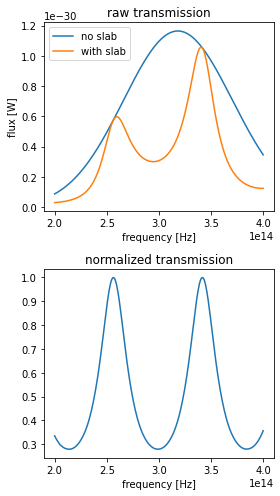

In [21]:
# Retrieve the power flux through the monitor plane.
transmission0 = sim_bw_data0['flux']
transmission = sim_bw_data['flux']
transmission_normalized = transmission / transmission0

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 7), tight_layout=True)
transmission0.plot(ax=ax1, label='no slab')
transmission.plot(ax=ax1, label='with slab')
transmission_normalized.plot(ax=ax2)
ax1.legend()
ax1.set_title('raw transmission')
ax2.set_title('normalized transmission')
plt.show()

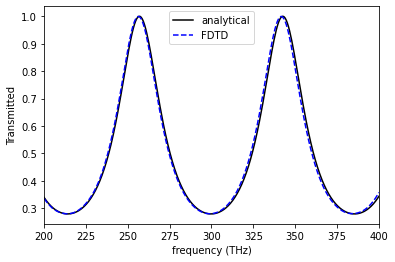

In [22]:
plt.figure()
plt.plot(monitor_freqs/1e12, transmission_analytical, 'k', label='analytical')
plt.plot(monitor_freqs/1e12, transmission_normalized, 'b--', label='FDTD')
plt.xlabel('frequency (THz)')
plt.xlim([200, 400])
plt.ylabel('Transmitted')
plt.legend()
plt.show()

These results look much better.